<a href="https://colab.research.google.com/github/fabio-r-almeida/Dissertation/blob/main/Disserta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
#@title ***Dissertation*** - **Vertical Photovoltaic Systems**
#@markdown **Bibliography**

#@markdown [News Article Agro-PV](https://cleantechnica.com/2022/07/25/new-research-says-vertical-solar-panels-have-improved-performance/)

#@markdown [News Article Agro-PV](https://www.pv-magazine.com/2022/05/09/intersolar-products-vertical-pv-system-for-green-rooftops/)

#@markdown [News Article Agro-PV](https://www.pv-magazine.com/2021/12/13/frances-first-vertical-bifacial-solar-power-plant/)

#@markdown [Case Study Optimal Tilt](https://web.stanford.edu/group/efmh/jacobson/Articles/I/TiltAngles.pdf)

#@markdown [Concept for Ago-PV](https://www.next2sun.de/en/our-concept/)
!pip install geopy -q
!pip install requests -q
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import calendar
import seaborn as sns




# ***Chapter 1*** - **Year Irradiance analysis**





/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


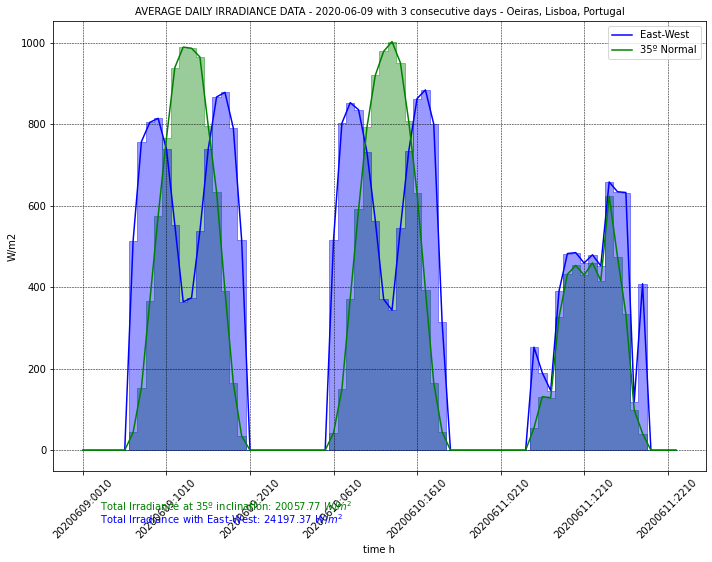

In [ ]:
#@title <center>PVGIS - Hourly radiation </center> { display-mode: "form" }

from datetime import date
##@markdown ![sad](https://www.pv-magazine.com/wp-content/uploads/2020/02/Bifaziale-Solaranlagen-im-Sommer-c-Next2Sun-Mounting-Systems-GmbH-1024x513.jpg)

#@markdown ---
#@markdown To fetch the necessary data from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) it is necessary to select the following parameters:
#@markdown * Latitude.
#@markdown * Longitude.
#@markdown * Start Year - Year from which the simulation starts.
#@markdown * End Year - Year in which the simulation ends.
#@markdown * Optimal Azimuth:
#@markdown  * If **checked**, it will be calculated the best azimuth for the selected location .
#@markdown  * If **unckeded**, it will be considered an azimuth of 0º.
#@markdown * Slope - This represents the inclination of the module.
#@markdown * Normal Slope - This represents the normalized slope for the modules (35º).


#@markdown ---
##@markdown ![sad](https://raw.githubusercontent.com/fabio-r-almeida/Dissertation/main/Files/Azimuth-Altitude_schematic%20(1).svg?token=GHSAT0AAAAAABY3B4RBE42AN6HL2QHVL5MUYZF46JQ)
#@markdown # Parameters 

from geopy.geocoders import Nominatim
geolocator = Nominatim()
City = "Oeiras" #@param {type:"string"}
location = geolocator.geocode(str(City))

Latitude = location.latitude 
Longitude = location.longitude


Start_Year = "2020" #@param ["2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
End_Year = "2020" #@param ["2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]


Optimal_Azimuth = True #@param {type:"boolean"}
Slope = 90 #@param ["90"] {type:"raw"}
Normal_Slope = 35 #@param ["35","90"] {type:"raw"}

#@markdown ---
#@markdown # Visualize  
Show_Graph = True #@param {type:"boolean"}

#@markdown Date must be in range of Start_Year and End_Year.
#@markdown * Start_Year starts January 1st.
#@markdown * End_Year ends December 31st.
#@markdown * Consecutive_Days is the number of consecutive days that will be displayed on the graph.

Visualize_Date = "2020-06-09" #@param {type:"date"}
Consecutive_Days = 3 #@param {type:"integer"}
if(Consecutive_Days<1):
  Consecutive_Days = 1

year = Visualize_Date.split("-")[0]
month = Visualize_Date.split("-")[1]
day = Visualize_Date.split("-")[2]

last_date = date(int(year), int(month), int(day))
first_date = date(int(Start_Year), 1, 1)
delta = last_date - first_date
delta = delta.days*24


url = f" https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={Latitude}&lon={Longitude}&startyear={Start_Year}&endyear={End_Year}&optimalangles={int(Optimal_Azimuth==True)}&angle={Slope}&outputformat=json"
#Gets the data from the url defined previously
api_response = requests.get(url)

#Converts into readable json
api_response_json = api_response.json()
data = json.loads(json.dumps(api_response_json))

azimuth = data['inputs']['mounting_system']['fixed']['azimuth']['value']
azimuth_east = azimuth + 90
azimuth_west= azimuth - 90

url_east = f" https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={Latitude}&lon={Longitude}&startyear={Start_Year}&endyear={End_Year}&aspect={azimuth_east}&angle={Slope}&outputformat=json"
url_west = f" https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={Latitude}&lon={Longitude}&startyear={Start_Year}&endyear={End_Year}&aspect={azimuth_west}&angle={Slope}&outputformat=json"
url_normal = f" https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={Latitude}&lon={Longitude}&startyear={Start_Year}&endyear={End_Year}&aspect={azimuth}&angle={Normal_Slope}&outputformat=json"


api_response_east = requests.get(url_east)
api_response_json_east = api_response_east.json()
data_east = json.loads(json.dumps(api_response_json_east))
df_east = pd.DataFrame(data_east['outputs']['hourly'])
df_east.columns = ['Time', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
df_east.set_index('Time', inplace=True)

api_response_west = requests.get(url_west)
api_response_json_west = api_response_west.json()
data_west = json.loads(json.dumps(api_response_json_west))
df_west = pd.DataFrame(data_west['outputs']['hourly'])
df_west.columns = ['Time', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
df_west.set_index('Time', inplace=True)

api_response_normal = requests.get(url_normal)
api_response_json_normal = api_response_normal.json()
data_normal = json.loads(json.dumps(api_response_json_normal))
df_normal = pd.DataFrame(data_normal['outputs']['hourly'])
df_normal.columns = ['Time', 'G(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
df_normal.set_index('Time', inplace=True)

df_east_west = df_east.add(df_west, fill_value=0)

#Plots
if(Show_Graph):

  fig, ax = plt.subplots();

  df_east_west['G(i)'].iloc[delta:delta+Consecutive_Days*24].plot(figsize=(11.69,8.27),  ax=ax, fontsize=10, color='b');
  df_normal['G(i)'].iloc[delta:delta+Consecutive_Days*24].plot(figsize=(11.69,8.27), ax=ax, fontsize=10, color = 'g');


  plt.text(2, -150, f'Total Irradiance at 35º inclination: {round(df_normal["G(i)"].iloc[delta:delta+Consecutive_Days*24].sum(),2)} $W/m^2$', fontsize = 10, color='g');
  plt.text(2, -180, f'Total Irradiance with East-West: {round(df_east_west["G(i)"].iloc[delta:delta+Consecutive_Days*24].sum(),2)} $W/m^2$', fontsize = 10, color='b');

  plt.title(f"AVERAGE DAILY IRRADIANCE DATA - {Visualize_Date} with {Consecutive_Days} consecutive days - {location}", fontsize= 10);
  ax.legend(["East-West", "35º Normal"], prop={'size': 10});
  ax.set_ylabel('W/m2', fontsize= 10);
  ax.set_xlabel('time h', fontsize= 10);

  plt.fill_between(df_normal.iloc[delta:delta+Consecutive_Days*24].index,df_normal['G(i)'].iloc[delta:delta+Consecutive_Days*24], step="mid", alpha=0.4, color='g')
  plt.fill_between(df_east_west.iloc[delta:delta+Consecutive_Days*24].index,df_east_west['G(i)'].iloc[delta:delta+Consecutive_Days*24], step="mid", alpha=0.4, color='b')

  plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
  plt.xticks(rotation=45);



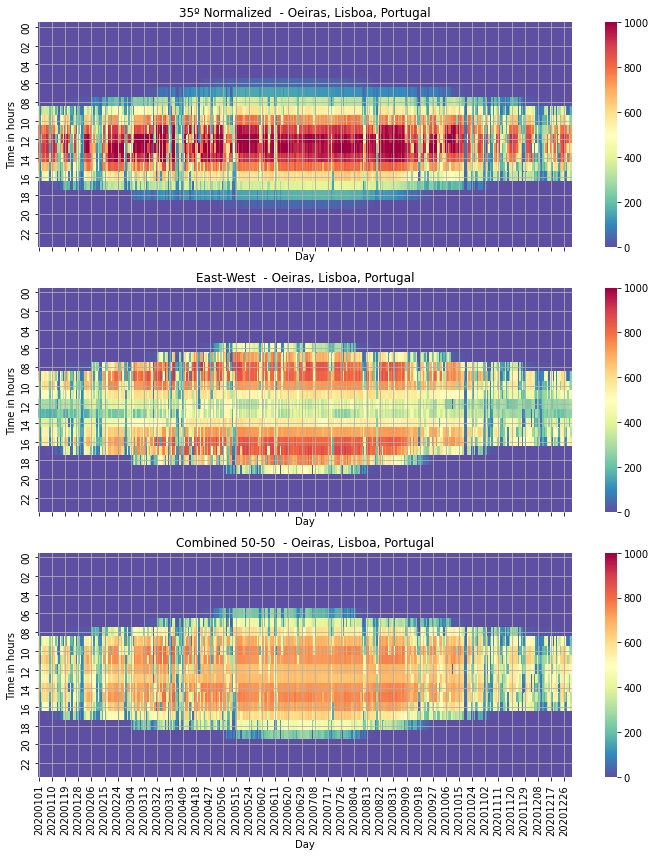

In [ ]:
#@title Heatmaps of the last year { run: "auto", display-mode: "form" }
Show_Graph = True #@param {type:"boolean"}

df_east_west_modified = df_east_west.copy()
df_normal_modified = df_normal.copy()
#@markdown Percentage of East-West modules used:
East_West = 50 #@param {type:"slider", min:0, max:100, step:1}

df_east_west_modified['G(i)'] = df_east_west_modified['G(i)'] * (East_West/100)
df_normal_modified['G(i)'] = df_normal_modified['G(i)'] * (100-East_West)/100
df_combined = df_normal_modified.add(df_east_west_modified, fill_value=0)


heatmap_data_normal = df_normal.iloc[-(365 + calendar.isleap(int(End_Year)))*24:].copy()
heatmap_data_normal = heatmap_data_normal.drop(columns=['H_sun', 'T2m', 'WS10m', 'Int'], axis=1)
heatmap_data_normal['Day'] = heatmap_data_normal.index.str[0:8] 
heatmap_data_normal['Time in hours' ] = heatmap_data_normal.index.str[9:11]
heatmap_data_normal = heatmap_data_normal.reset_index(drop=True)


heatmap_data_east_west = df_east_west.iloc[-(365 + calendar.isleap(int(End_Year)))*24:].copy()
heatmap_data_east_west = heatmap_data_east_west.drop(columns=['H_sun', 'T2m', 'WS10m', 'Int'], axis=1)
heatmap_data_east_west['Day'] = heatmap_data_east_west.index.str[0:8]
heatmap_data_east_west['Time in hours'] = heatmap_data_east_west.index.str[9:11]
heatmap_data_east_west = heatmap_data_east_west.reset_index(drop=True)

heatmap_data_combined = df_combined.iloc[-(365 + calendar.isleap(int(End_Year)))*24:].copy()
heatmap_data_combined = heatmap_data_combined.drop(columns=['H_sun', 'T2m', 'WS10m', 'Int'], axis=1)
heatmap_data_combined['Day'] = heatmap_data_combined.index.str[0:8]
heatmap_data_combined['Time in hours'] = heatmap_data_combined.index.str[9:11]
heatmap_data_combined = heatmap_data_combined.reset_index(drop=True)

if(Show_Graph):
  #Plots
  fig, ax = plt.subplots(3,figsize=(10,12),sharex=True);

  pivot_normal = heatmap_data_normal.pivot(index='Time in hours', columns='Day', values='G(i)')
  pivot_east_west = heatmap_data_east_west.pivot(index='Time in hours', columns='Day', values='G(i)')
  pivot_combined= heatmap_data_combined.pivot(index='Time in hours', columns='Day', values='G(i)')

  sns.heatmap(pivot_normal,ax=ax[0],cmap="Spectral_r",vmin=0, vmax=1000)
  sns.heatmap(pivot_east_west,ax=ax[1],cmap="Spectral_r",vmin=0, vmax=1000)
  sns.heatmap(pivot_combined,ax=ax[2],cmap="Spectral_r",vmin=0, vmax=1000)

  ax[0].set_title(f'35º Normalized  - {location}');
  ax[1].set_title(f'East-West  - {location}');
  ax[2].set_title(f'Combined {East_West}-{100-East_West}  - {location}');

  ax[0].grid()
  ax[1].grid()
  ax[2].grid()
  plt.tight_layout()





#***Chapter 2*** - **Monthly Averages Irradiance analysis**

In [ ]:
#@title <center>PVGIS - Average daily irradiance </center> {display-mode: "form" }
#@markdown ---
#@markdown To fetch the necessary data from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) it is necessary to select the following parameters:
#@markdown * Latitude.
#@markdown * Longitude.
#@markdown * Month - The month it will calculate
#@markdown * Optimal Azimuth:
#@markdown  * If **checked**, it will be calculated the best azimuth for the selected location .
#@markdown  * If **unckeded**, it will be considered an azimuth of 0º.
#@markdown * Slope - This represents the inclination of the module.
#@markdown * Normal Slope - This represents the normalized slope for the modules (35º).


#@markdown --- 
##@markdown ![sad](https://raw.githubusercontent.com/fabio-r-almeida/Dissertation/main/Files/Azimuth-Altitude_schematic%20(1).svg?token=GHSAT0AAAAAABY3B4RBE42AN6HL2QHVL5MUYZF46JQ)
#@markdown # Parameters 
   
from geopy.geocoders import Nominatim
geolocator = Nominatim()
City = "Caparica" #@param {type:"string"}
location = geolocator.geocode(str(City))

Latitude = location.latitude 
Longitude = location.longitude

Month = "July" #@param ["All","January", "February", "March", "April", "May", "June", "July","August", "September", "October", "November", "December"]
index = ["All","January", "February", "March", "April", "May", "June", "July","August", "September", "October", "November", "December"].index(Month)

Optimal_Azimuth = True #@param {type:"boolean"}
Slope = 90 #@param ["90"] {type:"raw"}
Normal_Slope = 35 #@param ["35"] {type:"raw"}


url = f" https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={Latitude}&lon={Longitude}&optimalangles={int(Optimal_Azimuth==True)}&angle={Slope}&outputformat=json"

#Gets the data from the url defined previously
api_response = requests.get(url)
#Converts into readable json
api_response_json = api_response.json()
data = json.loads(json.dumps(api_response_json))

#Gets and calculates the azimuth for the west-east modules
azimuth = data['inputs']['mounting_system']['fixed']['azimuth']['value']
azimuth_east = azimuth + 90
azimuth_west= azimuth - 90

#recalles new data with the updated azimuth
url_east = f" https://re.jrc.ec.europa.eu/api/v5_2/DRcalc?lat={Latitude}&lon={Longitude}&month={index}&aspect={azimuth_east}&angle={Slope}&showtemperatures=1&global=1&outputformat=json"
url_west = f" https://re.jrc.ec.europa.eu/api/v5_2/DRcalc?lat={Latitude}&lon={Longitude}&month={index}&aspect={azimuth_west}&angle={Slope}&showtemperatures=1&global=1&outputformat=json"
url_normal = f" https://re.jrc.ec.europa.eu/api/v5_2/DRcalc?lat={Latitude}&lon={Longitude}&month={index}&aspect={azimuth}&angle={Normal_Slope}&showtemperatures=1&global=1&outputformat=json"

#transforms de requested data into a dataframe with the labels bellow, deleting the Month label
#East modules
api_response_east = requests.get(url_east)
api_response_json_east = api_response_east.json()
data_east = json.loads(json.dumps(api_response_json_east))
df_east = pd.DataFrame(data_east['outputs']['daily_profile'])
df_east.columns = ['Month', 'Time', 'G(i)', 'Gb(i)', 'Gd(i)', 'T2m']
df_east.set_index('Time', inplace=True)
df_east = df_east.drop(['Month'], axis=1)

#transforms de requested data into a dataframe with the labels bellow, deleting the Month label
#West modules
api_response_west = requests.get(url_west)
api_response_json_west = api_response_west.json()
data_west = json.loads(json.dumps(api_response_json_west))
df_west = pd.DataFrame(data_west['outputs']['daily_profile'])
df_west.columns = ['Month', 'Time', 'G(i)', 'Gb(i)', 'Gd(i)', 'T2m']
df_west.set_index('Time', inplace=True)
df_west = df_west.drop(['Month'], axis=1)

#transforms de requested data into a dataframe with the labels bellow, deleting the Month label
#35º Modules
api_response_normal = requests.get(url_normal)
api_response_json_normal = api_response_normal.json()
data_normal = json.loads(json.dumps(api_response_json_normal))
df_normal = pd.DataFrame(data_normal['outputs']['daily_profile'])
df_normal.columns = ['Month', 'Time', 'G(i)', 'Gb(i)', 'Gd(i)', 'T2m']
df_normal.set_index('Time', inplace=True)
df_normal = df_normal.drop(['Month'], axis=1)

#Combines both West and East modules, since they are to be considered bi-facial
df_east_west = df_east.add(df_west, fill_value=0)

#Plots
fig, ax = plt.subplots();

df_east_west['G(i)'].iloc[:].plot(figsize=(11.69,8.27),  ax=ax, fontsize=10, color='b');
df_normal['G(i)'].iloc[:].plot(figsize=(11.69,8.27), ax=ax, fontsize=10, color = 'g');


plt.text(2, -150, f'Total Irradiance at 35º inclination: {round(df_normal["G(i)"].iloc[:].sum(),2)} $W/m^2$', fontsize = 10, color='g');
plt.text(2, -180, f'Total Irradiance with East-West: {round(df_east_west["G(i)"].iloc[:].sum(),2)} $W/m^2$', fontsize = 10, color='b');


plt.title(f"AVERAGE DAILY IRRADIANCE DATA - {Month} - {location}", fontsize= 10);
ax.legend(["East-West", "35º Normal"], prop={'size': 10});
ax.set_ylabel('W/m2', fontsize= 10);
ax.set_xlabel('time h', fontsize= 10);

plt.fill_between(df_normal.index,df_normal['G(i)'], step="mid",hatch='\\\\', alpha=0.4, color='g')
plt.fill_between(df_east_west.index,df_east_west['G(i)'], step="mid",hatch='//', alpha=0.4, color='b')

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.xticks(range(0,len(df_east_west.index)), df_east_west.index);
plt.xticks(rotation=45);


/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
#@title ***Live Comparison***{ run: "auto", display-mode: "form" }
#@markdown ---
#@markdown Live Comparison between
#@markdown * East-West Vertical Modules
#@markdown * 35º Inclination Modules

#@markdown The main scope of this chapter is to have a visual comparison between a range of configurations that the  Photovoltaic panels can be placed in. For this, it is possible to move the slider bellow which will change the amount of **Vertical Solar Modules** installed.
#@markdown The checkboxes enable and/or disable lines on the graph below.

#@markdown ---
df_east_west_modified = df_east_west.copy()
df_normal_modified = df_normal.copy()
#@markdown Percentage of East-West modules used:
East_West = 50 #@param {type:"slider", min:0, max:100, step:1}

#@markdown Configuration with all 35º Inclination Modules:
Show_35 = True #@param {type:"boolean"}
#@markdown Configuration with all East-West Modules:
Show_east_west = True #@param {type:"boolean"}
#@markdown Configuration with all mixed Modules:
Show_config = True #@param {type:"boolean"}
Legenda = []

df_east_west_modified['G(i)'] = df_east_west_modified['G(i)'] * (East_West/100)
df_normal_modified['G(i)'] = df_normal_modified['G(i)'] * (100-East_West)/100
df_combined = df_normal_modified.add(df_east_west_modified, fill_value=0)

fig, ax = plt.subplots();
if(Show_35):
  df_normal['G(i)'].iloc[:].plot(figsize=(11.69,8.27), ax=ax, fontsize=10, color = 'g');
  plt.text(0, -150, f'Total Irradiance at 35º inclination: {round(df_normal["G(i)"].iloc[:].sum(),2)} $W/m^2$', fontsize = 11, color='g');
  plt.fill_between(df_normal.index,df_normal['G(i)'], step="mid",hatch='\\', alpha=0.1, color='g')
  Legenda.append("35º Normal")

if(Show_east_west):
  df_east_west['G(i)'].iloc[:].plot(figsize=(11.69,8.27),  ax=ax, fontsize=10, color='b');
  plt.text(0, -180, f'Total Irradiance with East-West: {round(df_east_west["G(i)"].iloc[:].sum(),2)} $W/m^2$', fontsize = 11, color='b');
  plt.fill_between(df_east_west.index,df_east_west['G(i)'], step="mid",hatch='//', alpha=0.1, color='b')
  Legenda.append("East-West")

if(Show_config):
  df_combined['G(i)'].iloc[:].plot(figsize=(11.69,8.27), ax=ax, fontsize=10, color = 'r',  linestyle = '--',);
  plt.text(0, -210, f'Total Irradiance Combined: {round(df_combined["G(i)"].iloc[:].sum(),2)} $W/m^2$', fontsize = 11, color='r');
  plt.fill_between(df_combined.index,df_combined['G(i)'], step="mid",hatch='||', alpha=0.2, color='r')
  Legenda.append(f"East-West & 35º {int(East_West)}/{int((100-East_West))}")

plt.title(f"AVERAGE DAILY IRRADIANCE DATA - {Month}", fontsize= 10);
ax.legend(Legenda, prop={'size': 10});
ax.set_ylabel('W/m2', fontsize= 10);
ax.set_xlabel('time h', fontsize= 10);

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5);
plt.xticks(range(0,len(df_east_west.index)), df_east_west.index);
plt.xticks(rotation=45);


# ***Chapter 3*** - **Introduction to Calculations and Comparisons**

##Comparisons
As seen previously, using just this the East-West configuration, during the summer months it is possible to receive more Irradiance on the modules than on the conventional 35º inclination. Furthermore it is interesting to note that the East-West configuration changes the typical curvature of the Photovoltaic system to a "double hill" format, starting to produce energy earlier and stopping later than the 35º inclination.

Next, It will be testes combining both approaches to better understand if they can work together and in that way creating a more stable and longer lasting energy production, even if it has a lower peak.

---

<p align="center">
  <img src="https://raw.githubusercontent.com/fabio-r-almeida/Dissertation/main/Files/vertical_panels_2.png" />
</p>

#Benefits to be tested on the East-West Configuration
* It might reduce the overall wear of the modules since it has less solar exposure on the hottest hours of the day.
* It might not destroy the soil since it lets light shine through (during the lowest production hours) making it a good approach for agriculture.
* It might reduce the windblown deposit of dust since it has a vertical orientation.
* It can have a more consistent curve and easier to manage by the distribuitor.

 --- 

# Calculation
The calculations will be performed following four steps.


\begin{align*}
& T_{cell} = T_{amb}+\frac{NOCT - 20}{800} \cdot G \\\\
& P_{DC_{max}} = \frac{P_{STC} \cdot G}{1000}\\\\
& ΔT = T_{cell}-25\\\\
& PV = P_{DC_{max}} \cdot (1 + \alpha_p \cdot ΔT )\\\\
\end{align*}


  






## Distance between Vertical Solar Panels

---
\\
\
\begin{align*}
& D = h \cdot \left( cos(\alphaº) + \frac{sin(\alphaº)}{tan(\beta_Nº)} \right)\\\\
\end{align*}
* $h$ - Height of the Structute/Panels.
* $\alpha$ - Slope of the Panels (Vertical = 90º).
* $\beta_N$ - Solar height.


---

\begin{align*}
& \beta_N  = 90 - L + \deltaº  \\\\
\end{align*}
* $L$ - Latitude of the location.
* $\delta$ - Winter Solstice (-23.45º) is the worst-case scenario.


---
\begin{align*}
& \delta = 23.45º \cdot sin \left(\frac{360º}{365}\right)\cdot(n-81)  \\\\
\end{align*}
* $n$ - number of days since the begining of the year.

---

<p align="center">
  <img src="https://raw.githubusercontent.com/fabio-r-almeida/Dissertation/main/Files/winter.png" />
</p>




In [ ]:
import math
print(3*(math.cos(90*math.pi/180) + (math.sin(90*math.pi/180))/(math.tan(23.45*math.pi/180))))

# ***Chapter 4*** - **Real Location Simulation**

In this chapter, it will be considered 3 locations in portugal where agriculture already exists in great extend and where Agro-PV could be integrated.

The main scope of this simulation is to better visualize the effect of integrating a mixed configuration.

What is going to be studied:

1. Yearly Energy Production
2. Preservation of the Biodiversity
3. Efficient use of the plot
4. Yearly Profit



In [ ]:
#@title **Location Selection**{ run: "auto", display-mode: "form" }
City_1 = "Baixo Alentejo" #@param {type:"string"}
City_2 = "Terceira" #@param {type:"string"}
City_3 = "Santarem" #@param {type:"string"}

#@markdown Plotting area in hectares
Plotting_Area = 10 #@param {type:"number"}

plot_area = Plotting_Area*10000

location_1 = geolocator.geocode(str(City_1))
location_2 = geolocator.geocode(str(City_2))
location_3 = geolocator.geocode(str(City_3))

print(location_1, f"({location_1.longitude}, {location_1.latitude})")
print(location_2, f"({location_2.longitude}, {location_2.latitude})")
print(location_3, f"({location_3.longitude}, {location_3.latitude})")

In [25]:
#@title # **Photovoltaic Bifacial Modules Selection**{ run: "auto", display-mode: "form" }

#@markdown Bifacial Module                      |Power      | Price   |-| Module                           | Power      | Price
#@markdown -------------------------------------|-----------|---------| |----------------------------------|------------|--------
#@markdown **LG Neon 2 Bifacial LG410N2T-L5**   | 410 W     | €245.00 | | **LG Neon R LG370Q1C-V5**        | 370 W      | €297.00
#@markdown **LG Neon 2 Bifacial LG415N2T-L5**   | 415 W     | €274.00 | | **LG Neon R LG360Q1C-A5**        | 360 W      | €296.00
#@markdown **LG Neon 2 Bifacial LG400N2T-A5**   | 400 W     | €249.00 | | **LG Neon R Prime LG355Q1K-V5**  | 355 W      | €262.00
#@markdown **LG Neon 2 Bifacial LG430N2T-E6**   | 430 W     | €270.00 | | **LG Neon R Prime LG360Q1K-V5**  | 360 W      | €309.00
#@markdown **LG Neon H Bifacial LG435N2T-E6**   | 435 W     | €319.00 | | **LG Neon 2 LG335N1C-A5**        | 335 W      | €215.00
#@markdown **LG Neon 2 Bifacial LG335N1T-V5**   | 335 W     | €211.00 | | **LG Neon 2 LG340N1C-V5**        | 340 W      | €203.00
#@markdown **LG Neon 2 Bifacial LG425N2T-E6**   | 425 W     | €265.00 | | **LG Neon 2 LG350N1C-V5**        | 350 W      | €211.00
#@markdown **LG Neon 2 Bifacial LG400N2T-J5**   | 400 W     | €249.00 | | **LG Neon H LG380N1C-E6**        | 380 W      | €245.00
#@markdown
#@markdown ---
#@markdown
#@markdown #**Module Selection**
Vertical_Modules = "LG Neon 2 Bifacial LG415N2T-L5" #@param ["LG Neon 2 Bifacial LG410N2T-L5", "LG Neon 2 Bifacial LG415N2T-L5", "LG Neon 2 Bifacial LG400N2T-A5", "LG Neon 2 Bifacial LG430N2T-E6", "LG Neon H Bifacial LG435N2T-E6", "LG Neon 2 Bifacial LG335N1T-V5", "LG Neon 2 Bifacial LG425N2T-E6", "LG Neon 2 Bifacial LG400N2T-J5"]
Horizontal_Modules = "LG Neon 2 LG335N1C-A5" #@param ["LG Neon R LG370Q1C-V5", "LG Neon R LG360Q1C-A5", "LG Neon R LG370Q1C-V5", "LG Neon R Prime LG355Q1K-V5", "LG Neon R Prime LG360Q1K-V5", "LG Neon 2 LG335N1C-A5", "LG Neon 2 LG340N1C-V5", "LG Neon 2 LG350N1C-V5", "LG Neon H LG380N1C-E6*"]


if(Horizontal_Modules == "LG Neon R LG370Q1C-V5"):
  Max_Power = 370
  UMPP = 37.0
  IMPP = 10.01
  Uoc = 42.8
  Isc = 10.82
  Efficiency = 21.4
  NOCT = 44
  alpha_p = -0.30
  dimension_L = 1.016
  dimension_H = 1.70
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon R LG360Q1C-V5"):
  Max_Power = 360
  UMPP = 36.5
  IMPP = 9.87
  Uoc = 42.7
  Isc = 10.79
  Efficiency = 20.8
  NOCT = 44
  alpha_p = -0.30
  dimension_L = 1.016
  dimension_H = 1.70
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon R Prime LG355Q1K-V5"):
  Max_Power = 355
  UMPP = 36.4
  IMPP = 9.76
  Uoc = 43.1
  Isc = 10.44
  Efficiency = 20.6
  NOCT = 44
  alpha_p = -0.30
  dimension_L = 1.016
  dimension_H = 1.70
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon R Prime LG360Q1K-V5"):
  Max_Power = 360
  UMPP = 36.7
  IMPP = 9.82
  Uoc = 43.3
  Isc = 10.5
  Efficiency = 20.8
  NOCT = 44
  alpha_p = -0.30
  dimension_L = 1.016
  dimension_H = 1.70
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon 2 LG335N1C-A5"):
  Max_Power = 335
  UMPP = 34.1
  IMPP = 9.83
  Uoc = 41.0
  Isc = 10.49
  Efficiency = 19.6
  NOCT = 42
  alpha_p = -0.36
  dimension_L = 1.016
  dimension_H = 1.686
  dimension_W = 0.04
  
if(Horizontal_Modules == "LG Neon 2 LG340N1C-V5"):
  Max_Power = 340
  UMPP = 34.5
  IMPP = 9.86
  Uoc = 41.1
  Isc = 10.53
  Efficiency = 19.8
  NOCT = 42
  alpha_p = -0.36
  dimension_L = 1.016
  dimension_H = 1.686
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon 2 LG350N1C-V5"):
  Max_Power = 350
  UMPP = 35.3
  IMPP = 9.92
  Uoc = 41.3
  Isc = 10.61
  Efficiency = 20.4
  NOCT = 42
  alpha_p = -0.36
  dimension_L = 1.016
  dimension_H = 1.686
  dimension_W = 0.04

if(Horizontal_Modules == "LG Neon H LG380N1C-E6"):
  Max_Power = 380
  UMPP = 35.1
  IMPP = 10.85
  Uoc = 41.7
  Isc = 11.39
  Efficiency = 20.6
  NOCT = 42
  alpha_p = -0.33
  dimension_L = 1.042
  dimension_H = 1.768
  dimension_W = 0.04